# AYAHUASCA MICE

THEY DIDN'T PUBLISH THE METADATA SO WE HAVE TO FLY BY THE SEAT OF OUR PANTS BUT IT SHOULD BE OK, THOSE ARE MOUSE BRAIN CELL TYPES AFTER ALL

In [24]:
import scanpy as sc
import anndata as ad

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from platython import normalise as pn
from anticor_features.anticor_features import get_anti_cor_genes
import topo as tp
from topo.tpgraph.intrinsic_dim import IntrinsicDim

In [2]:
_psilo = sc.read_10x_mtx("/Users/npapadop/Documents/teaching/2024/GSE246451/psilo/")
_psilo.obs.index = _psilo.obs.index.str.replace("-1", "-p")
_psilo.obs["condition"] = "psilocybin"
_saline = sc.read_10x_mtx("/Users/npapadop/Documents/teaching/2024/GSE246451/saline/")
_saline.obs.index = _saline.obs.index.str.replace("-1", "-s")
_saline.obs["condition"] = "saline"

In [3]:
adata = ad.concat((_psilo, _saline))
del _psilo, _saline

In [4]:
adata

AnnData object with n_obs × n_vars = 6958392 × 32285
    obs: 'condition'

from the paper:

> To remove low quality cells and likely multiplet captures, we filtered out cells with features < 700, mitochondrial gene percentage > 5%, then removed doublets with DoubletFinder (v2.0.3, RRID:SCR_018771) 69. Possible estimation and removal of cell free mRNA contamination was removed with SoupX (v.1.6.0, RRID:SCR_019193) 70. Gene expression differences were identified between Saline and Psilocybin samples (N = 4/group) using DESeq2 (v1.38.0, RRID:SCR_015687) 71. The enrichment analysis was performed with clusterProfiler (v4.8.1, RRID:SCR_016884) 72 and ReactomePA (v1.44.0, RRID:SCR_019316) 73.

In [5]:
sc.pp.filter_cells(adata, min_genes=700)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 25018 × 25328
    obs: 'condition', 'n_genes'
    var: 'n_cells'

Identify mitochondrial genes, which are an important quality control indicator:

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_

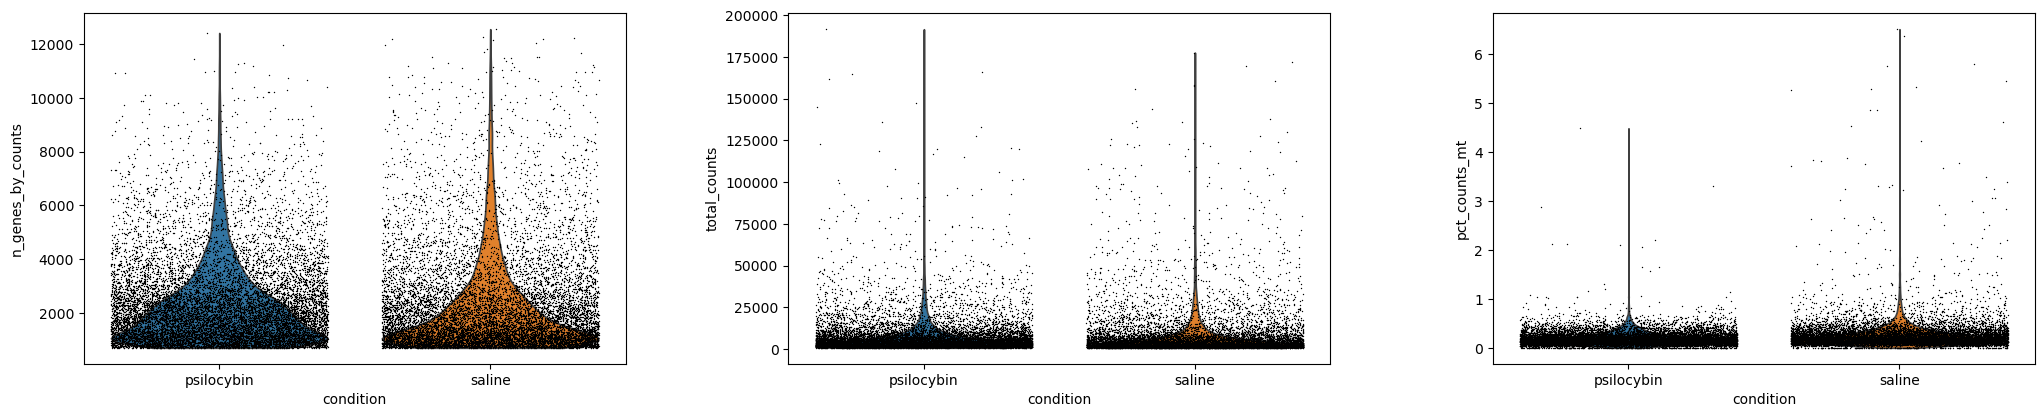

In [7]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby="condition"
)

amazing quality, we can keep all of those since we probably won't have problems.

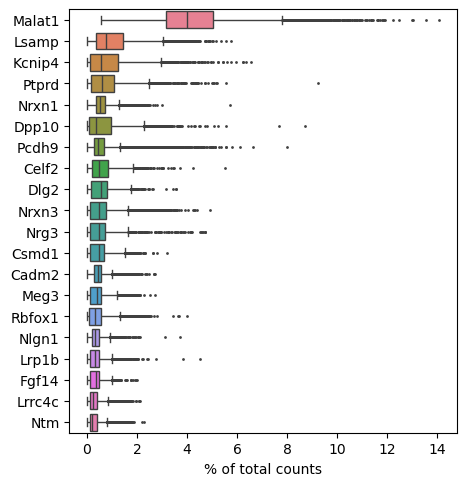

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

again, exceptional quality. Usually a lot of counts are wasted on metabolism/ribosomal stuff.

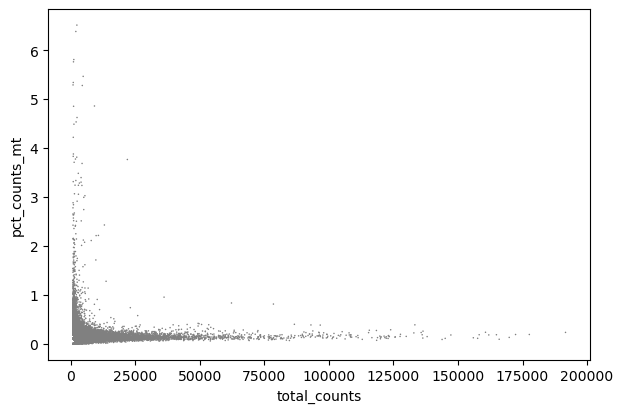

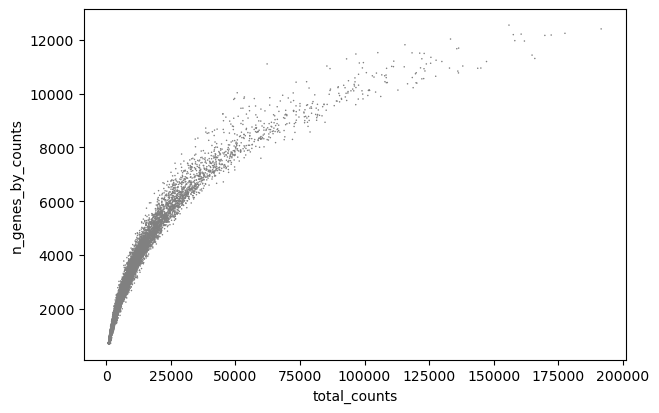

In [9]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

The points on the far right are on fraud alert, but we can deal with them later

In [10]:
marker_genes = ["Ptgds", "Rgs5", "Pecam1", "Opalin", "Mog", "Pdgfra",
                "Cx3cr1", "Acsbg1", "Vip", "Sst", "Pvalb", "Lamp5",
                "Gad2", "Dlx6os1", "Foxp2", "Rorb", "Il1rapl1",
                "Arhgap15", "Pld5", "Slc17a7", "Snap25"]

check that I typed the genes correctly:

In [11]:
present = [any(adata.var.index.str.contains(gene)) for gene in marker_genes]
assert all(present)

## Normalisation

In [12]:
pn.PFlogPF(adata)

## Informative gene selection

In [13]:
anti_cor_table = get_anti_cor_genes(adata.X.T,
                                    adata.var.index.tolist(),
                                    species="mmusculus")

selected_table = anti_cor_table[anti_cor_table["selected"]==True]
print(selected_table)

found 784.814559232 free Gb in /var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T
get_all_remove_genes
25018 1250
min_express_n 50
get_n_expressed
pathways_to_genes
    0              1    2                   3       4  \
0  g#  initial alias   c#     converted alias    name   
1   1     GO:0044429  1.1  ENSMUSG00000020477  MRPS24   
2   1     GO:0044429  1.2  ENSMUSG00000048429  TIMM29   
3   1     GO:0044429  1.3  ENSMUSG00000023827  AGPAT4   
4   1     GO:0044429  1.4  ENSMUSG00000061979   RCC1L   

                                                   5           6  
0                                        description  namespaces  
1  mitochondrial ribosomal protein S24 [Source:MG...        None  
2  translocase of inner mitochondrial membrane 29...        None  
3  1-acylglycerol-3-phosphate O-acyltransferase 4...        None  
4  reculator of chromosome condensation 1 like [S...        None  
get_ensg_of_ref
    0              1                   2      3                4  \
0  g#  i

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


empirically determined Cneg cutoff: -0.01870334957954134  for FPR of: 0.001
empirically determined Cpos cutoff: 0.02864593430177948  for FPR of: 0.001
get_real_spear
[0, 5000, 10000, 15000, 16268]
working on 0 5000 vs 5000 10000
	getting spearman correlation
working on 0 5000 vs 10000 15000
	getting spearman correlation
working on 0 5000 vs 15000 16268
	getting spearman correlation
working on 5000 10000 vs 10000 15000
	getting spearman correlation
working on 5000 10000 vs 15000 16268
	getting spearman correlation
working on 10000 15000 vs 15000 16268
	getting spearman correlation


/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/anticor_features/anticor_features.py:402: RuntimeWarning: divide by zero encountered in scalar divide
  FDR_vect[i] = FP_hat_vect[i]/all_sig_neg_vect[i]


                        gene  pre_remove_feature  pre_remove_pathway  \
Xkr4                    Xkr4               False               False   
Gm1992                Gm1992               False               False   
Gm19938              Gm19938               False               False   
Sox17                  Sox17               False               False   
Rgs20                  Rgs20               False               False   
...                      ...                 ...                 ...   
Uty                      Uty               False               False   
Gm21860              Gm21860               False               False   
Gm47283              Gm47283               False               False   
4933409K07Rik  4933409K07Rik               False               False   
AC149090.1        AC149090.1               False               False   

               pre_remove_low_express  n_expressed  percent_expressed  \
Xkr4                            False      18036.0           0

In [14]:
adata.var = pd.concat([adata.var, anti_cor_table], axis=1)

In [15]:
adata.var["highly_variable"] = adata.var["selected"].fillna(False)

/var/folders/md/d6lwwbv97xb6g6ddypntnprh0000gp/T/ipykernel_35672/1485543714.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.var["highly_variable"] = adata.var["selected"].fillna(False)


## Dimensionality estimation

In [16]:
hvg = adata[:, adata.var["highly_variable"] == True].copy()

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/topo/base/ann.py:124: UserWarning: hnswlib does not support sparse matrices. Converting to array...
  warn("hnswlib does not support sparse matrices. Converting to array...")


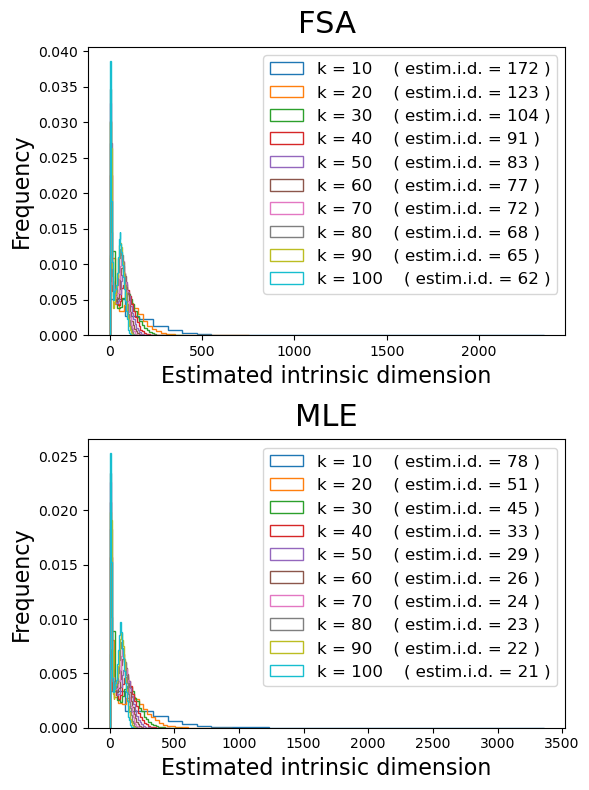

In [17]:
id_est = IntrinsicDim(
    methods=['fsa', 'mle'], # the methods we'll use
    k=range(10, 110, 10), # the number of k-neighbors to test
    backend='hnswlib',  # the approximate kNN backend to use
    metric='cosine', # the distance metric to use
    n_jobs=-1, # the number of jobs to run in parallel
    plot=True, # whether to plot the results during fit()
    random_state=None) # the random state to use for colors

# Estimate the i.d.
id_est.fit(hvg.X)

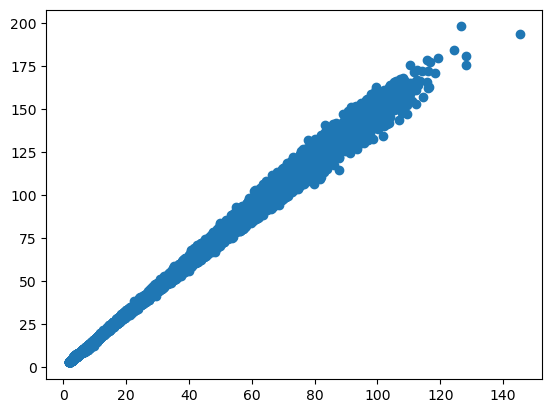

Spearman R correlation: 0.999


In [20]:
from scipy.stats import spearmanr

# Compare the results for 100 k-nearest-neighbors
fsa_local = id_est.local_id['fsa']['100']
mle_local = id_est.local_id['mle']['100']

corr, _ = spearmanr(fsa_local, mle_local)

plt.scatter(fsa_local, mle_local)
plt.show()

print('Spearman R correlation: %.3f' % corr)

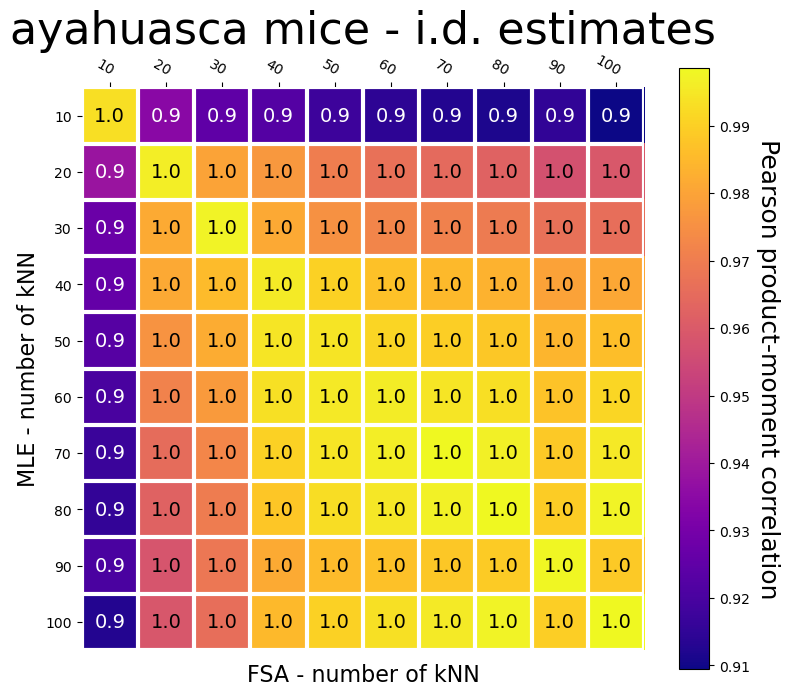

In [25]:
# Compute correlation between the i.d. estimates for each kNN value
keys = []
corr = []
for i_id, k_fsa in enumerate(id_est.local_id['fsa']):
    keys.append(k_fsa)
    for i_id, k_mle in enumerate(id_est.local_id['mle']):
        corr.append(spearmanr(id_est.local_id['fsa'][k_fsa], id_est.local_id['mle'][k_mle])[0])

# Create square array of correlations from the list
cor_array = np.array(corr).reshape((10, 10))
cor_array

# Plot as a heatmap
fig, ax = plt.subplots(figsize=(8,8))

im, cbar = tp.pl.heatmap(cor_array, keys, keys, ax=ax,
                   cmap="plasma", cbarlabel="Pearson product-moment correlation", cbar_fontsize=18, shrink=0.8, cb_pad=0.05)

# Annotated heatmap
texts = tp.pl.annotate_heatmap(im, valfmt="{x:.1f}", textcolors=("white", "black"), an_fontsize=14)

ax.set_xlabel('FSA - number of kNN', fontsize=16)
ax.set_ylabel('MLE - number of kNN', fontsize=16)
ax.set_title('ayahuasca mice - i.d. estimates', fontsize=32)
fig.tight_layout()
plt.show()

In [26]:
# Create TopOGraph object using 20 kNN
tg = tp.TopOGraph(base_knn=30, 
                    n_eigs=150, # set this to the largest estimate!
                    n_jobs=-1,
                    verbosity=0)

# Run a TopOMetry model
hvg = tp.sc.topological_workflow(
    hvg,                  # the anndata object
    tg,                # the TopOGraph object
    kernels=['bw_adaptive'],# the kernel(s) to use
    eigenmap_methods=['DM'],# the eigenmap method(s) to use
    projections=['MAP'],    # the projection(s) to use
    resolution=2.0          # the Leiden clustering resolution
)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/topo/base/ann.py:124: UserWarning: hnswlib does not support sparse matrices. Converting to array...
  warn("hnswlib does not support sparse matrices. Converting to array...")


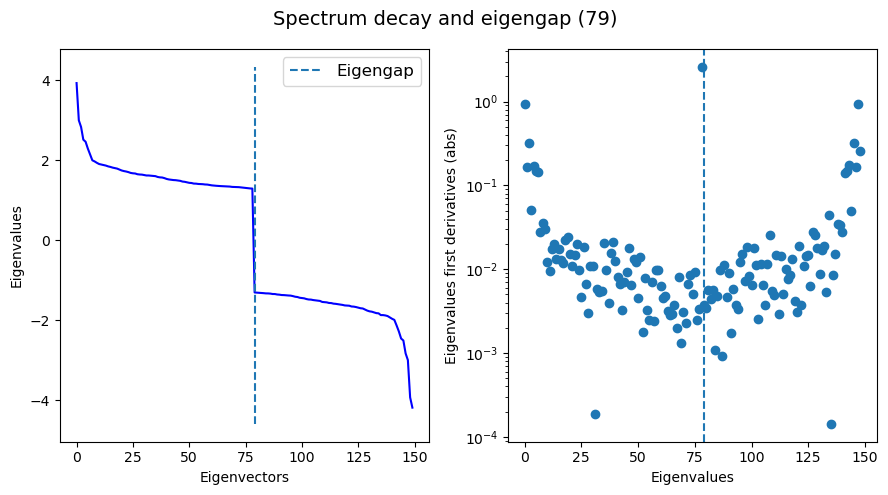

In [27]:
tg.eigenspectrum()

In [28]:
adata.uns["proposed_dimensionality"] = 80

In [29]:
from sklearn.decomposition import PCA
from umap import UMAP

sc.pp.scale(hvg, max_value=10)

pca_op = PCA(n_components=adata.uns["proposed_dimensionality"]) # compute similar amount of components for fair comparison
pca_Y = pca_op.fit_transform(hvg.X)

umap_PCA = UMAP(n_components=2, metric='cosine').fit_transform(pca_Y)

In [31]:
evaluation_dict = tp.pipes.eval_models_layouts(tg, hvg.X,
                                                    kernels=['bw_adaptive'],
                                                    eigenmap_methods=['msDM','DM','LE'],
                                                    projections=['MAP'],
                                                    additional_eigenbases={"PCA_scale": pca_Y},
                                                    additional_projections={'UMAP': umap_PCA},
                                                    n_neighbors=3,
                                                    n_pcs=adata.uns["proposed_dimensionality"],
                                                    n_jobs=-1
                                                )

In [32]:
pd.DataFrame(evaluation_dict)

,Eigenbasis - Trustworthiness,Eigenbasis - Geodesic correlation,Eigenbasis - Global score,Projection - Trustworthiness,Projection - Geodesic correlation,Projection - Global score
DM with bw_adaptive,0.911491,0.330235,0.957661,NaN,NaN,NaN
msDM with bw_adaptive,0.906983,0.251261,0.936549,NaN,NaN,NaN
LE with bw_adaptive,0.920600,-0.275069,0.955887,NaN,NaN,NaN
PCA,0.979856,0.173940,NaN,NaN,NaN,NaN
PCA_scale,0.979778,0.113118,1.000000,NaN,NaN,NaN
MAP of bw_adaptive from DM with bw_adaptive,NaN,NaN,NaN,0.868000,0.270114,0.980117
MAP of bw_adaptive from msDM with bw_adaptive,NaN,NaN,NaN,0.857116,0.257878,0.979114
MAP of bw_adaptive from LE with bw_adaptive,NaN,NaN,NaN,0.856741,0.373528,0.980032
UMAP,NaN,NaN,NaN,0.931761,0.086385,0.992764


In [37]:
# save best embeddings
adata.obsm["X_PCA"] = pca_Y
adata.obsm["X_DM"] = tg.EigenbasisDict['DM with bw_adaptive'].results()

# save two best projections
adata.obsm["X_topo"] = tg.ProjectionDict['MAP of bw_adaptive from DM with bw_adaptive']
adata.obsm["X_umap"] = umap_PCA

# keep track of our choices
adata.uns["X_topo"] = 'MAP of bw_adaptive from LE with bw_adaptive'
adata.uns["topo_eval_dict"] = evaluation_dict

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


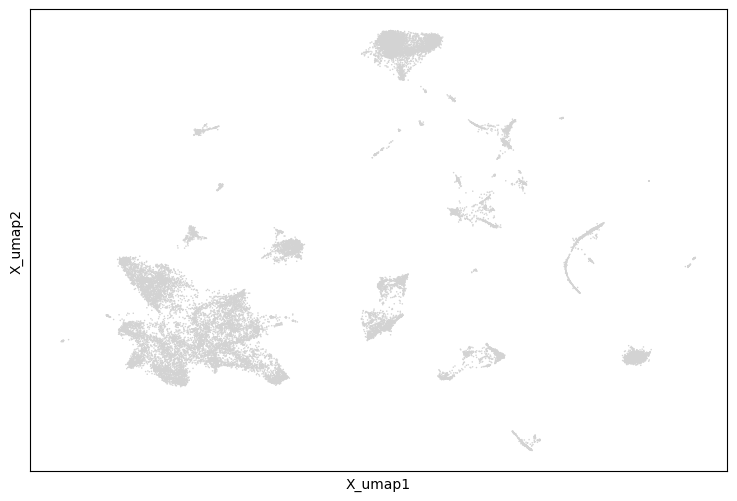

In [39]:
fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.embedding(adata, basis="X_umap", ax=ax)

## Cluster analysis

In [41]:
from platython import cluster as pc

In [58]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_DM", metric="cosine", n_pcs=80)

In [59]:
sc.tl.leiden(adata, resolution=1.)
pc.merge_clusters(adata, "leiden", num_genes=40)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


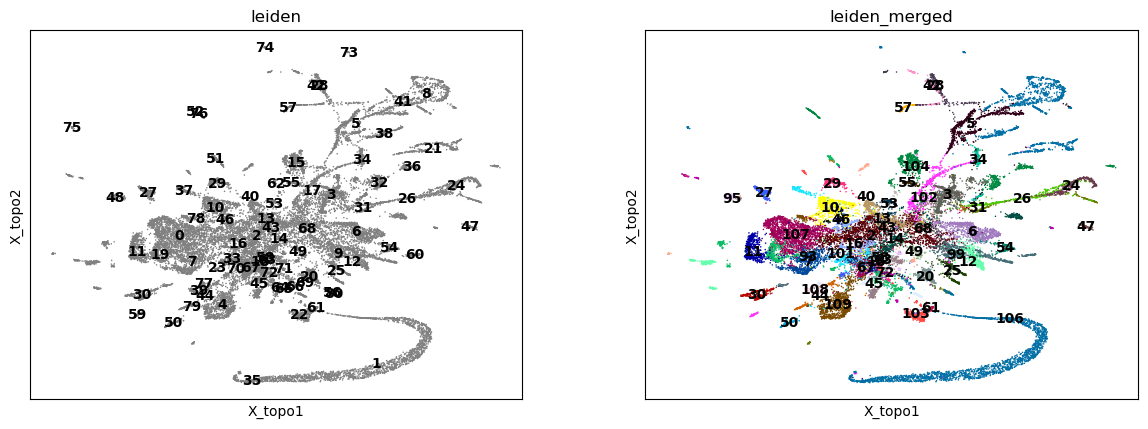

In [60]:
sc.pl.embedding(adata, basis="X_topo", color=["leiden", "leiden_merged"], legend_loc="on data")

In [61]:
sc.tl.dendrogram(adata, groupby="leiden_merged", use_rep="X_DM")

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


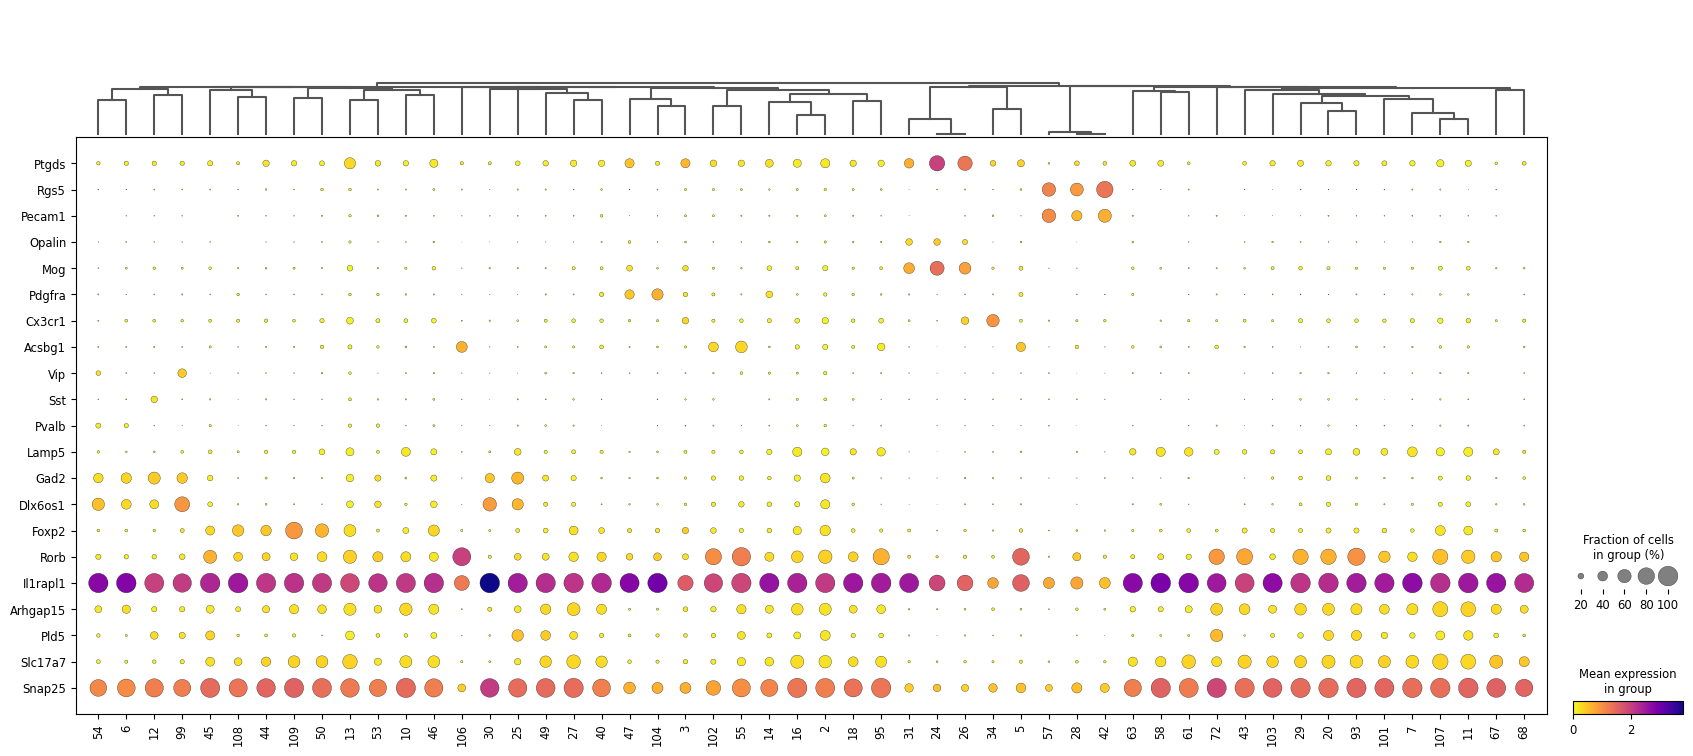

In [63]:
sc.pl.dotplot(adata, groupby="leiden_merged", var_names=marker_genes, swap_axes=True, cmap="plasma_r", dendrogram=True)

In [ ]:
sc.tl.paga(adata, "leiden_merged")